本质上讲，我们每次不同的抽卡都可以视为独立同分布的数值采样，我们可以将其简单地视为首先将不同卡片根据其设计好的概率数值摆放在0到1这个区间内，然后每次抽卡则在0到1中随机选取一个数字，根据此前已摆放好的卡片映射得到抽卡结果。

在Python中，random库中的choices函数已经为我们实现好了给定相对概率的采样，从而无需重复造轮子，直接调用即可。

比如，最简单的抽卡游戏：抛硬币正反面

In [1]:
import random

In [2]:
def toss_coin(N:int):
    assert N > 0
    return random.choices(population=['正', '反'], weights=[1, 1], k=N)

In [5]:
toss_coin(10)

['反', '正', '正', '正', '反', '反', '正', '反', '正', '反']


在实际的游戏中，略有不同的地方在于
 - 卡片通常会有一些固定的分类，比如江南百景图中的 天、侯、卿士 三种级别；游戏开发团队可能会需要不定时根据类别进行概率调整，或者调整某一特定类别中一张或多张卡片的概率
 - 为了保障玩家（非酋）的游戏体验，总是会设计一些保底机制防止人类心态爆炸，例如江南百景图中的金卷轴十连必出侯

这两个额外的需求我们可以通过两个设计实现：
 - 单次抽卡分解为两次随机采样，第一次采样决定级别，第二次采样决定该级别内具体角色（类似于ARPG游戏中先染色）
 - 十连首先在保底级别中进行一次抽卡，比如先从 天、侯 级别中抽卡一次，剩下九次进行常规抽卡

按照这个思路，我们可以先简单设计一个只考虑人物等级的精英卡池抽卡模拟器

In [52]:
# 简单模拟一下精英卡池等级抽卡

级别列表 = ['天', '侯', '卿', '士']
级别相对概率 = [6, 26, 68, 0]

def draw(k=1):
    if k==10:
        保底 = random.choices(级别列表[:2], weights=级别相对概率[:2], k=1)
        剩余 = random.choices(级别列表, weights=级别相对概率, k=9)
        return 保底+剩余

    if k!=1:
        raise ValueError("目前仅支持单抽或十连！")
        
    return random.choices(级别列表, weights=级别相对概率, k=k)

虽然仍然非常粗糙，这个仍然可以提供给我们许多信息：我们可以用它来测试单抽和十连的不同结果。

In [131]:
def 十连(repeat=100):
    results = [draw(k=10) for rep in range(repeat)]
    return [r for sub_res in results for r in sub_res]

def 单抽(repeat=1000):
    results = [draw(k=1) for rep in range(repeat)]
    return [r for sub_res in results for r in sub_res]

根据大数定律，只要重复次数足够多，试验中某事件的频率就会逼近其真实的概率。

据此我们可以尝试用百万十连测试十连的等效单次出天率。

In [129]:
重复次数 = 1000000
十连(repeat=重复次数).count('天') / (重复次数*10)

0.0726011

In [132]:
重复次数 = 10000000
单抽(repeat=重复次数).count('天') / (重复次数)

0.0598872

可以看到，百万十连告诉我们十连的等效单次出天率在7%左右，比单抽高了一个百分点。

我们假设某氪佬/肝佬，十连一百次，然后再单抽一千次，看看两次的分布有啥不一样。

In [159]:
import numpy as np
import matplotlib.pyplot as plt

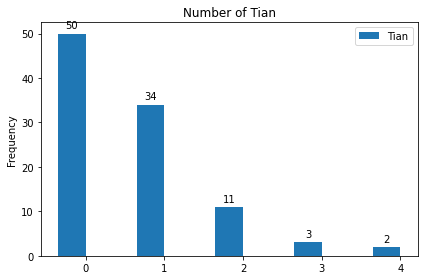

In [189]:
repeat = 100
results = [draw(k=10) for rep in range(repeat)]
十连天数表 = [result.count('天') for result in results]
labels, counts = np.unique(十连天数表, return_counts=True)


x = labels  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, counts, width, label='Tian')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency')
ax.set_title('Number of Tian')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
# autolabel(rects2)

fig.tight_layout()

plt.show()

惊了，该欧皇居然有两次十连出了4天，恐怖如斯。